In [18]:

import numpy as np
from numba import njit
import edlib


def get_rc(s):
    map_dict = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G', 'N': 'N'}
    l = []
    for c in s:
        l.append(map_dict[c])
    l = l[::-1]
    return ''.join(l)
def rc(s):
    map_dict = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G', 'N': 'N'}
    l = []
    for c in s:
        l.append(map_dict[c])
    l = l[::-1]
    return ''.join(l)

def seq2hashtable_multi_test(refseq, testseq, kmersize=15, shift = 1):
    rc_testseq = get_rc(testseq)
    testseq_len = len(testseq)
    local_lookuptable = dict()
    skiphash = hash('N'*kmersize)
    for iloc in range(0, len(refseq) - kmersize + 1, 1):
        hashedkmer = hash(refseq[iloc:iloc+kmersize])
        if(skiphash == hashedkmer):
            continue
        if(hashedkmer in local_lookuptable):

            local_lookuptable[hashedkmer].append(iloc)
        else:
            local_lookuptable[hashedkmer] = [iloc]
    iloc = -1
    readend = testseq_len-kmersize+1
    one_mapinfo = []
    preiloc = 0
    while(True):
   
        iloc += shift
        if(iloc >= readend):
            break

        #if(hash(testseq[iloc: iloc + kmersize]) == hash(rc_testseq[-(iloc + kmersize): -iloc])):
            #continue
 
        hashedkmer = hash(testseq[iloc: iloc + kmersize])
        if(hashedkmer in local_lookuptable):

            for refloc in local_lookuptable[hashedkmer]:

                one_mapinfo.append((iloc, refloc, 1, kmersize))



        hashedkmer = hash(rc_testseq[-(iloc + kmersize): -iloc])
        if(hashedkmer in local_lookuptable):
            for refloc in local_lookuptable[hashedkmer]:
                one_mapinfo.append((iloc, refloc, -1, kmersize))
        preiloc = iloc

    

    return np.array(one_mapinfo)

def get_points(tuples_str):
    data = []
    num = 0
    for c in tuples_str:
        if(ord('0') <= c <= ord('9')):
            num = num * 10 + c - ord('0')
        elif(ord(',') == c):
            data.append(num)
            num = 0
    if(num != 0):
        data.append(num)
    return data

def calculate_distance(ref, query, ref_st, ref_en, query_st, query_en):
    A = ref[ref_st: ref_en]
    a = query[query_st: query_en]
    _a = rc(query[query_st: query_en])
    return min(edlib.align(A, a)['editDistance'], edlib.align(A, _a)['editDistance'])

def get_first(x):
    return x[0]


def calculate_value(tuples_str, ref, query):  

    slicepoints = np.array(get_points(tuples_str.encode()))
    if(len(slicepoints) > 0 and len(slicepoints) % 4 == 0):
        editdistance = 0
        aligned = 0
        preend = 0
        points = np.array(slicepoints).reshape((-1, 4)).tolist()
        points.sort(key=get_first)
        for onetuple in points:
            query_st, query_en, ref_st, ref_en = onetuple
            if(preend > query_st):
                return 0
            if(query_en - query_st < 30):
                continue
            preend = query_en
            if((calculate_distance(ref, query, ref_st, ref_en, query_st, query_en)/len(query[query_st:query_en])) > 0.1):
                continue
            editdistance += calculate_distance(ref, query, ref_st, ref_en, query_st, query_en)
            aligned += len(query[query_st:query_en])
        return max(aligned - editdistance, 0)
    else:
        return 0


In [19]:
from collections import defaultdict
from itertools import combinations

# 1. 一个小函数，计算一个 DNA 串的反向互补
def revcomp(seq: str) -> str:
    comp = {'A':'T','T':'A','C':'G','G':'C'}
    return ''.join(comp[c] for c in reversed(seq))

print(revcomp('ATCG'))

# 2. 建两个索引：正向和倒位
def build_bi_strand_index(reference: str, k: int, d: int):
    """
    返回：
      masks,             # LSH 掩码列表
      idx_pos, idx_neg   # 两个 List[Dict]，分别是正向和倒位索引
    """
    masks = list(combinations(range(k), k - d))
    idx_pos = []  # 正向索引
    idx_neg = []  # 倒位索引（对反向互补建表）
    rc_ref = revcomp(reference)
    
    n=len(reference)

    for mask in masks:
        m_pos = defaultdict(list)
        m_neg = defaultdict(list)
        for i in range(n - k + 1):
            kmer_pos = reference[i:i+k]
            key_pos = hash(tuple(kmer_pos[p] for p in mask))
            m_pos[key_pos].append(i)

            kmer_neg=rc_ref[n-(i+k):n-(i)]
            key_neg = hash(tuple(kmer_neg[p] for p in mask))
            m_neg[key_neg].append(i)
            
            
            
        idx_pos.append(m_pos)
        idx_neg.append(m_neg)

    return masks, idx_pos, idx_neg

# 3. 查 query 时，同一个 k-mer 既在正向，也在倒位里查
def match_bi_strand(query: str, k: int, d: int, masks, idx_pos, idx_neg):
    """
    返回 List[(q_pos, r_pos, strand)]
    strand = +1 (正向) 或 -1 (倒位)
    """
    anchors = []
    anchors_r = []
    for q in range(len(query) - k + 1):
        kmer = query[q:q+k]
        # kmer_rc = revcomp(kmer)
        for mask, m_pos, m_neg in zip(masks, idx_pos, idx_neg):
            key = hash(tuple(kmer[p] for p in mask))
            for r in m_pos.get(key, []):
                anchors.append((q, r))
            for r in m_neg.get(key, []):
                anchors_r.append((q, r))
    # 去重
    return list(set(anchors)), list(set(anchors_r))

# —— 使用示例 —— #




CGAT


In [1]:
# ———————— 使用示例 ————————

# 假设：
# reference = "ACTGATCATGATCGTAGCT"  # 长百万级的字符串
# query     = "ACCGAACATGCTCGGAGAT"      # 待比对字符串
def read_sequence_from_file(path: str) -> str:
    """
    从文本文件读取 DNA 序列：
    - 忽略空行和首尾空白
    - 返回纯净的字符串（只包含 A/C/G/T）
    """
    with open(path, "r") as f:
        # 读取每一行，去掉首尾空白，过滤空行
        lines = [line.strip() for line in f if line.strip()]
    # 将多行拼接成一个连续序列
    return "".join(lines)

# 调用示例
reference = read_sequence_from_file("ref2.txt")
query     = read_sequence_from_file("que2.txt")

print(len(reference), len(query))
k, d      = 11, 2

# 1. 建双链索引
masks, idx_pos, idx_neg = build_bi_strand_index(reference, k, d)

# 2. 匹配
anchors ,anchors_r= match_bi_strand(query, k, d, masks, idx_pos, idx_neg)
print("anchors:", anchors[:10])
print("anchors_r:", anchors_r[:10])
# 每个元素是 (q_pos, r_pos, strand)

print("找到的锚点数量len(anchors)：", len(anchors))
print("部分锚点示例：", anchors[:10])
for i, (q_pos, r_pos) in enumerate(anchors[:10], 1):   #索引从1开始计数
    q_kmer = query[q_pos : q_pos + k]
    r_kmer = reference[r_pos : r_pos + k]
    print(f"{i:2d}. query[{q_pos:4d}:{q_pos+k:4d}] = {q_kmer}    "
          f"| reference[{r_pos:4d}:{r_pos+k:4d}] = {r_kmer} ")

print("找到的锚点数量len(anchors)：", len(anchors_r))
print("部分锚点示例：", anchors_r[:10])
for i, (q_pos, r_pos) in enumerate(anchors_r[:10], 1):   #索引从1开始计数
    q_kmer = query[q_pos : q_pos + k]
    r_kmer = reference[r_pos : r_pos + k]
    print(f"{i:2d}. query[{q_pos:4d}:{q_pos+k:4d}] = {q_kmer}    "
          f"| reference[{r_pos:4d}:{r_pos+k:4d}] = {r_kmer} ")


29830 29845


NameError: name 'build_bi_strand_index' is not defined

anchor q0=788, r0=838
anchor q1=405, r1=584
TATGACACCAAAAGATCTACCTACAGCCCG
CAGTACTGTAGGTATATCTTTTGGTGTCAT
TATGACACCA  AAAGATCTACC  TACAGCCCG
CAGTACTGTA  GGTATATCTTT  TGGTGTCAT


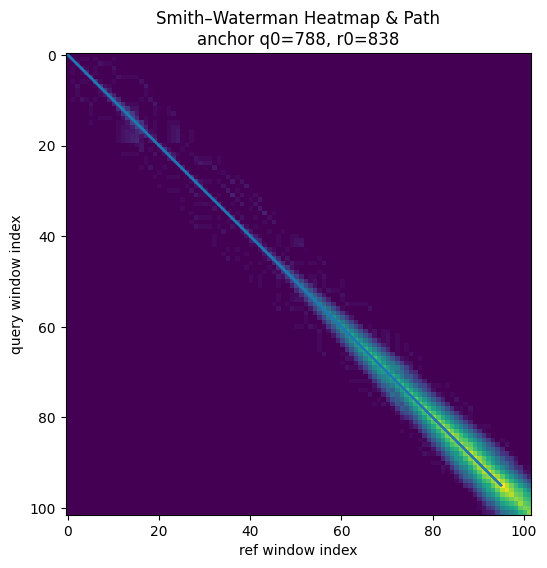

Aligned fragment:
 query[738:832] = GTGGCGTTTGCCCTCCCCCAGCTTGACTACTGTGCTCTAGGGCACGACGGGTGGCGTTTGCCCCCGCGCAGCTCGACTTTTGTGCTCTATGGCAC
 ref  [788:882] = GTGGCGTTTGCCCCCGTGCAGCCCGACTTTTGTACTCTAGTGCACGACGGGTGGCGTTTGCCCCCGCACCGCTCGACTTTTGTGATCTAGGGCAC
Best score: 92


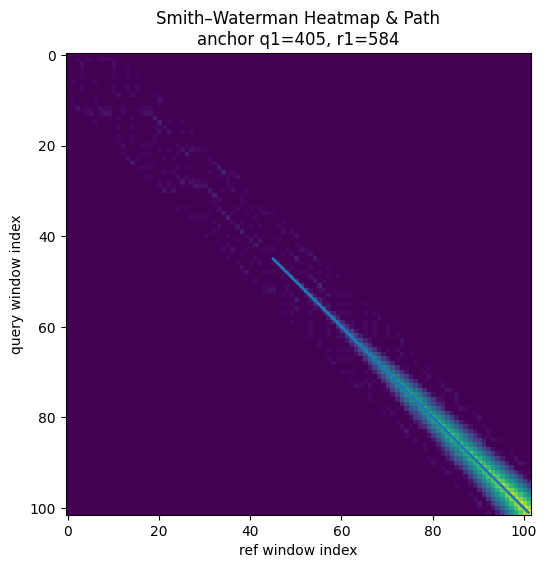

q_st: 400 q_en: 455 r_st: 544 r_en: 599 r_st_r: 1100 r_en_r: 1155
Aligned fragment:
 query[400:455] = CTGTAGGTATATCTTTTGGTGTCATATGAGGGTACTGAACTTGACGACCGCGACCA
 ref  [544:599] = TGGTCGCGGTCGTCAACTTCAGTACGCTCATATGACACCAAAAGATCTACCTACAG
Best score: 91


In [21]:
import numpy as np 
import matplotlib.pyplot as plt





def compute_banded_sw_matrix(ref, query, r0, q0,
                             W=50, band=10,
                             match=2, mismatch=-5, gap=-10):
    """
    本函数返回：
      H:    (n+1)x(m+1) 的得分矩阵
      path: 回溯路径列表 [(i1,j1),...,(ik,jk)]
      q_lo, r_lo: 窗口在原始序列中的左边界
    """
    # 定义窗口
    q_lo = max(0, q0 - W); q_hi = min(len(query), q0 + W + 1)
    r_lo = max(0, r0 - W); r_hi = min(len(ref),   r0 + W + 1)
    n, m = q_hi - q_lo, r_hi - r_lo

    # 初始化
    H = np.zeros((n+1, m+1), dtype=int)
    best_score, bi, bj = 0, 0, 0

    # 填表
    for i in range(1, n+1):
        j_start = max(1, i - band)
        j_end   = min(m, i + band)
        for j in range(j_start, j_end+1):
            sc = match if query[q_lo+i-1] == ref[r_lo+j-1] else mismatch
            diag = H[i-1, j-1] + sc
            up   = H[i-1, j]   + gap
            left = H[i,   j-1] + gap
            H[i, j] = val = max(0, diag, up, left)
            if val > best_score:
                best_score, bi, bj = val, i, j

    # 回溯
    path = []
    i, j = bi, bj
    while i>0 and j>0 and H[i, j] > 0:
        path.append((i, j))
        sc = match if query[q_lo+i-1] == ref[r_lo+j-1] else mismatch
        if H[i, j] == H[i-1, j-1] + sc:
            i, j = i-1, j-1
        elif H[i, j] == H[i-1, j] + gap:
            i -= 1
        else:
            j -= 1
    path.append((i, j))
    path.reverse()
    return H, path, q_lo, r_lo


# 选一个 anchor，比如第 1 个
q0, r0 = anchors[0]
q1, r1 = anchors_r[5]

reference_r=revcomp(reference)
print(f"anchor q0={q0}, r0={r0}")
print(f"anchor q1={q1}, r1={r1}")
print(reference[r1-10:r1+20])
print(query[q1-10:q1+20])
print(reference[r1-10:r1]+'  '+reference[r1:r1+11]+'  '+reference[r1+11:r1+20])
print(query[q1-10:q1]+'  '+query[q1:q1+11]+'  '+query[q1+11:q1+20])

len_ref=len(reference) 


r1_r=(len_ref-1)-(r1+10)

# 计算矩阵和路径
H, path, q_lo, r_lo = compute_banded_sw_matrix(reference, query, r0, q0)

# 可视化得分矩阵和回溯路径
plt.figure(figsize=(6, 6))
plt.imshow(H, aspect='auto')
ys, xs = zip(*path)
plt.plot(xs, ys, linewidth=2)
plt.title(f"Smith–Waterman Heatmap & Path\nanchor q0={q0}, r0={r0}")
plt.xlabel("ref window index")
plt.ylabel("query window index")
plt.show()

# 将回溯结果映射回原始序列坐标并打印
i0, j0 = path[0]
bi, bj = path[-1]
q_st = q_lo + i0
q_en = q_lo + bi - 1
r_st = r_lo + j0
r_en = r_lo + bj - 1

print("Aligned fragment:")
print(f" query[{q_st}:{q_en}] = {query[q_st:q_en+1]}")
print(f" ref  [{r_st}:{r_en}] = {reference[r_st:r_en+1]}")
print("Best score:", H.max())

#_____________________________________________________________________________________



H, path, q_lo, r_lo = compute_banded_sw_matrix(reference_r, query, r1_r, q1)

# 可视化得分矩阵和回溯路径
plt.figure(figsize=(6, 6))
plt.imshow(H, aspect='auto')
ys, xs = zip(*path)
plt.plot(xs, ys, linewidth=2)
plt.title(f"Smith–Waterman Heatmap & Path\nanchor q1={q1}, r1={r1}")
plt.xlabel("ref window index")
plt.ylabel("query window index")
plt.show()

# 将回溯结果映射回原始序列坐标并打印
i0, j0 = path[0]
bi, bj = path[-1]
q_st = q_lo + i0
q_en = q_lo + bi - 1
r_st_r = r_lo + j0
r_en_r = r_lo + bj - 1

r_st=len_ref-1-r_en_r
r_en=len_ref-1-r_st_r
print("q_st:", q_st, "q_en:", q_en, "r_st:", r_st, "r_en:", r_en,"r_st_r:", r_st_r,"r_en_r:", r_en_r)

print("Aligned fragment:")
print(f" query[{q_st}:{q_en}] = {query[q_st:q_en+1]}")
print(f" ref  [{r_st}:{r_en}] = {reference[r_st:r_en+1]}")
print("Best score:", H.max())


In [22]:
import numpy as np

def compute_banded_sw_simple(ref, query, r0, q0,
                             W=100, band=10,
                             match=2, mismatch=-5, gap=-10):
    """
    带宽限制的 Smith-Waterman 局部对齐——简洁版
    输入:
      ref, query: DNA 序列
      r0, q0: 种子锚点在 ref/query 上的位置
      W: 窗口半宽度，band: 带宽优化
      match/mismatch/gap: 计分
    输出:
      (q_start, q_end, r_start, r_end, best_score)
    """
    # 1. 定义局部对齐窗口
    q_lo = max(0, q0 - W); q_hi = min(len(query), q0 + W + 1)
    r_lo = max(0, r0 - W); r_hi = min(len(ref),   r0 + W + 1)
    n, m = q_hi - q_lo, r_hi - r_lo

    # 2. DP 矩阵，只存两行滚动优化也可以，这里为了回溯保留全矩阵
    H = np.zeros((n+1, m+1), dtype=int)
    best, bi, bj = 0, 0, 0

    # 3. 填表
    for i in range(1, n+1):
        j0 = max(1, i - band); j1 = min(m, i + band)
        for j in range(j0, j1+1):
            s = match if query[q_lo+i-1] == ref[r_lo+j-1] else mismatch
            v = max(0,
                    H[i-1, j-1] + s,
                    H[i-1, j]   + gap,
                    H[i,   j-1] + gap)
            H[i, j] = v
            if v > best:
                best, bi, bj = v.item(), i, j

    # 4. 回溯到局部起点
    i, j = bi, bj
    while i>0 and j>0 and H[i, j] > 0:
        # 优先判断对角线
        if H[i, j] == H[i-1, j-1] + (match if query[q_lo+i-1]==ref[r_lo+j-1] else mismatch):
            i, j = i-1, j-1
        elif H[i, j] == H[i-1, j] + gap:
            i -= 1
        else:
            j -= 1

    # 5. 映射到全局坐标并返回
    q_start = q_lo + i
    q_end   = q_lo + bi - 1
    r_start = r_lo + j
    r_end   = r_lo + bj - 1
    return (q_start, q_end, r_start, r_end, best)

fragments=[]
fragments_r=[]

for q0,r0 in anchors:
    frag = compute_banded_sw_simple(reference, query, r0, q0,
                                    W=100, band=10,
                                    match=2, mismatch=-5, gap=-10)
    if frag:
        frag=frag+(1,)
        fragments.append(frag)
       
len_ref=len(reference) 
for q1,r1 in anchors_r:
    r1_r=(len_ref-1)-(r1+10)
    frag=compute_banded_sw_simple(reference_r, query, r1_r, q1,
                                    W=100, band=10,
                                    match=2, mismatch=-5, gap=-10)
    if frag:
        lst=list(frag)
        r_start_r=lst[2]
        r_end_r=lst[3]
        lst[2]=len_ref-1-r_end_r
        lst[3]=len_ref-1-r_start_r
        frag=tuple(lst)
        frag=frag+(-1,)
        fragments_r.append(frag)
        
        
print(len(fragments))
print(fragments[:10])

print(len(fragments_r))
print(fragments_r[:10])




#关键参数：W，band


5630
[(688, 832, 738, 882, 157, 1), (700, 874, 600, 774, 217, 1), (99, 150, 349, 400, 34, 1), (1500, 1613, 1000, 1113, 200, 1), (595, 795, 695, 895, 262, 1), (1749, 1897, 1099, 1247, 74, 1), (507, 633, 707, 833, 135, 1), (1721, 1756, 1171, 1206, 44, 1), (202, 269, 102, 169, 45, 1), (1002, 1136, 752, 886, 130, 1)]
1329
[(1200, 1299, 900, 999, 193, -1), (272, 278, 1198, 1204, 14, -1), (900, 997, 752, 849, 98, -1), (900, 999, 700, 799, 172, -1), (2438, 2443, 1430, 1435, 12, -1), (400, 500, 499, 599, 167, -1), (8, 11, 842, 845, 8, -1), (1175, 1185, 874, 884, 15, -1), (1124, 1132, 719, 727, 18, -1), (2054, 2067, 696, 709, 21, -1)]


In [23]:
qs, qe, rs, re, sc, strand = fragments[0]
print("正向第一个片段：")
print(f"  query[{qs}:{qe}]  = {query[qs:qe+1]}")
print(f"  ref  [{rs}:{re}]  = {reference[rs:re+1]}")
print(f"  score = {sc}, strand = {strand}")

# 打印反向匹配的第一个片段
qs, qe, rs, re, sc, strand = fragments_r[0]
print("\n反向第一个片段：")
print(f"  query[{qs}:{qe}]  = {query[qs:qe+1]}")
print(f"  ref  [{rs}:{re}]  = {reference[rs:re+1]}")
print(f"  score = {sc}, strand = {strand}")

正向第一个片段：
  query[688:832]  = GTGGCCTTTGCCCCCGCGCAGCTGGACTTTTGTGCTCTAGGGCACGGCGGGTGGCGTTTGCCCTCCCCCAGCTTGACTACTGTGCTCTAGGGCACGACGGGTGGCGTTTGCCCCCGCGCAGCTCGACTTTTGTGCTCTATGGCAC
  ref  [738:882]  = GTGGCGTTTGCCCTCGCCCAGCTTGACTTTTGTGCTCTAGGGCACGACGGGTGGCGTTTGCCCCCGTGCAGCCCGACTTTTGTACTCTAGTGCACGACGGGTGGCGTTTGCCCCCGCACCGCTCGACTTTTGTGATCTAGGGCAC
  score = 157, strand = 1

反向第一个片段：
  query[1200:1299]  = AGCTTTCCGTATCTACCTAATGTCTTCCTCTCAGACCCGTCTCACGGGCCAATGAGAAGCGCGGGGCCTATTAGAGAATCCATGTGCGTTGATCTGTCTG
  ref  [900:999]  = CAGACAGATCAACGCACATGGATTCTCTAACAGGCCCCGCGCTTCTCATTGGCCCGTGAGACGGGTCTGAGAGGAAGACATTAGGTAGATACGGAAAGCT
  score = 193, strand = -1


[(0, 200, 0, 200), (0, 199, 0, 199), (0, 198, 0, 198), (0, 194, 0, 194), (0, 194, 0, 194), (0, 194, 0, 194), (0, 194, 0, 194), (0, 193, 0, 193), (0, 192, 0, 192), (0, 191, 0, 191), (0, 190, 0, 190), (0, 189, 0, 189), (0, 188, 0, 188), (0, 187, 0, 187), (0, 186, 0, 186), (0, 185, 0, 185), (0, 184, 0, 184), (0, 183, 0, 183), (0, 182, 0, 182), (0, 181, 0, 181), (0, 180, 0, 180), (0, 179, 0, 179), (0, 178, 0, 178), (0, 177, 0, 177), (0, 176, 0, 176), (0, 175, 0, 175), (0, 174, 0, 174), (0, 173, 0, 173), (0, 172, 0, 172), (0, 171, 0, 171), (0, 170, 0, 170), (0, 169, 0, 169), (0, 168, 0, 168), (0, 167, 0, 167), (0, 166, 0, 166), (0, 165, 0, 165), (0, 164, 0, 164), (0, 163, 0, 163), (0, 162, 0, 162), (0, 161, 0, 161), (0, 160, 0, 160), (0, 152, 0, 152), (0, 152, 0, 152), (0, 152, 0, 152), (0, 152, 0, 152), (0, 152, 0, 152), (0, 152, 0, 152), (0, 152, 0, 152), (0, 152, 0, 152), (0, 151, 0, 151), (0, 150, 0, 150), (0, 149, 0, 149), (0, 148, 0, 148), (0, 147, 0, 147), (0, 146, 0, 146), (0, 145, 

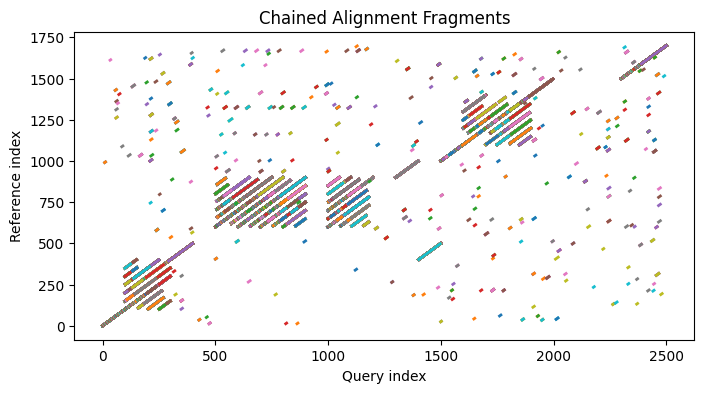

In [24]:
# 假设你已有 fragments 列表，每个元素是 (q_start, q_end, r_start, r_end, score)
# 下面实现贪心链式拼接

def chain_fragments_greedy(fragments):
    """
    输入:
      fragments: List of tuples (q_start, q_end, r_start, r_end, score)
    输出:
      chained: 按 Query 顺序、不重叠的最优贪心链
    """
    # 1. 按 q_start 升序；若相同则按 score 降序
    frags = sorted(fragments, key=lambda x: (x[0], -x[4]))
    chained = []
    ans=[]
    last_q_end = -1
    for qs, qe, rs, re, sc,_ in frags:
        # if qs > last_q_end:
        #   chained.append((qs, qe, rs, re, sc))
        #   ans.append((qs, qe, rs, re))
        #   last_q_end = qe
      
        chained.append((qs, qe, rs, re, sc))
        ans.append((qs, qe, rs, re))
        last_q_end = qe
    return chained,ans

# 调用示例
chained ,ans= chain_fragments_greedy(fragments)

print(ans)
print("Greedy Chained Fragments:")
for idx, (qs, qe, rs, re, sc) in enumerate(chained, 1):
    print(f"{idx}. query[{qs}:{qe}] ↔ ref[{rs}:{re}]  score={sc}")

# （可选）可视化每个片段在 Query/Ref 上的位置
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
for qs, qe, rs, re, sc in chained:
    plt.plot([qs, qe], [rs, re], linewidth=2)
plt.xlabel("Query index")
plt.ylabel("Reference index")
plt.title("Chained Alignment Fragments")
plt.show()





[(3, 7, 1513, 1517), (5, 8, 589, 592), (8, 11, 842, 845), (9, 12, 953, 956), (9, 12, 953, 956), (9, 12, 953, 956), (25, 28, 556, 559), (28, 40, 855, 867), (31, 34, 1424, 1427), (42, 48, 1354, 1360), (42, 48, 1354, 1360), (42, 47, 1155, 1160), (42, 47, 1155, 1160), (56, 60, 815, 819), (56, 60, 715, 719), (56, 60, 715, 719), (87, 91, 858, 862), (87, 91, 708, 712), (120, 125, 1444, 1449), (122, 126, 1604, 1608), (140, 145, 1282, 1287), (140, 145, 1480, 1485), (140, 145, 1282, 1287), (140, 145, 1282, 1287), (148, 154, 246, 252), (148, 154, 246, 252), (148, 154, 246, 252), (148, 154, 246, 252), (151, 156, 294, 299), (153, 157, 1115, 1119), (166, 171, 1066, 1071), (166, 171, 1066, 1071), (166, 171, 1066, 1071), (180, 189, 1563, 1572), (180, 189, 1563, 1572), (181, 193, 493, 505), (181, 193, 493, 505), (181, 193, 493, 505), (181, 193, 493, 505), (181, 193, 493, 505), (181, 193, 493, 505), (211, 219, 988, 996), (224, 229, 575, 580), (228, 235, 230, 237), (228, 235, 230, 237), (228, 235, 330, 3

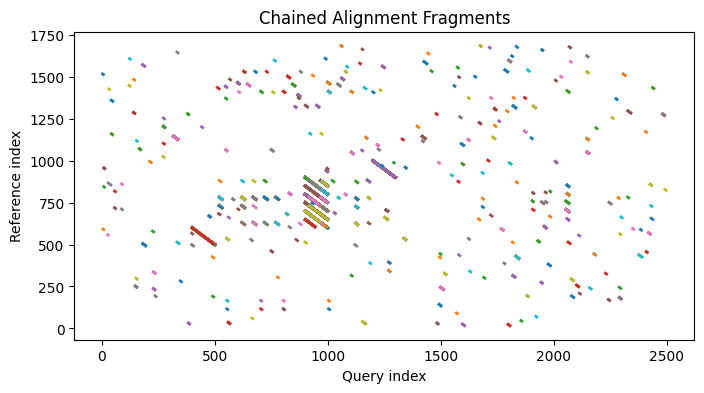

In [25]:
# 假设你已有 fragments 列表，每个元素是 (q_start, q_end, r_start, r_end, score)
# 下面实现贪心链式拼接

# 调用示例
chained_r ,ans_r= chain_fragments_greedy(fragments_r)

print(ans_r)
print("Greedy Chained Fragments:")
for idx, (qs, qe, rs, re, sc) in enumerate(chained, 1):
    print(f"{idx}. query[{qs}:{qe}] ↔ ref[{rs}:{re}]  score={sc}")

# （可选）可视化每个片段在 Query/Ref 上的位置
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
for qs, qe, rs, re, sc in chained_r:
    plt.plot([qs, qe], [re, rs], linewidth=2)
plt.xlabel("Query index")
plt.ylabel("Reference index")
plt.title("Chained Alignment Fragments")
plt.show()


[(0, 200, 0, 200), (0, 199, 0, 199), (0, 198, 0, 198), (0, 194, 0, 194), (0, 194, 0, 194), (0, 194, 0, 194), (0, 194, 0, 194), (0, 193, 0, 193), (0, 192, 0, 192), (0, 191, 0, 191), (0, 190, 0, 190), (0, 189, 0, 189), (0, 188, 0, 188), (0, 187, 0, 187), (0, 186, 0, 186), (0, 185, 0, 185), (0, 184, 0, 184), (0, 183, 0, 183), (0, 182, 0, 182), (0, 181, 0, 181), (0, 180, 0, 180), (0, 179, 0, 179), (0, 178, 0, 178), (0, 177, 0, 177), (0, 176, 0, 176), (0, 175, 0, 175), (0, 174, 0, 174), (0, 173, 0, 173), (0, 172, 0, 172), (0, 171, 0, 171), (0, 170, 0, 170), (0, 169, 0, 169), (0, 168, 0, 168), (0, 167, 0, 167), (0, 166, 0, 166), (0, 165, 0, 165), (0, 164, 0, 164), (0, 163, 0, 163), (0, 162, 0, 162), (0, 161, 0, 161), (0, 160, 0, 160), (0, 152, 0, 152), (0, 152, 0, 152), (0, 152, 0, 152), (0, 152, 0, 152), (0, 152, 0, 152), (0, 152, 0, 152), (0, 152, 0, 152), (0, 152, 0, 152), (0, 151, 0, 151), (0, 150, 0, 150), (0, 149, 0, 149), (0, 148, 0, 148), (0, 147, 0, 147), (0, 146, 0, 146), (0, 145, 

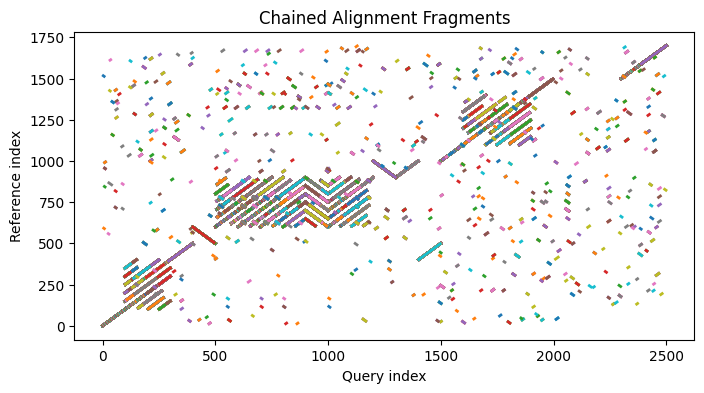

In [26]:
chained ,ans= chain_fragments_greedy(fragments)
chained_r ,ans_r= chain_fragments_greedy(fragments_r)


print(ans)
print("Greedy Chained Fragments:")
for idx, (qs, qe, rs, re, sc) in enumerate(chained, 1):
    print(f"{idx}. query[{qs}:{qe}] ↔ ref[{rs}:{re}]  score={sc}")
print(ans_r)
print("Greedy Chained Fragments:")
for idx, (qs, qe, rs, re, sc) in enumerate(chained, 1):
    print(f"{idx}. query[{qs}:{qe}] ↔ ref[{rs}:{re}]  score={sc}")
# （可选）可视化每个片段在 Query/Ref 上的位置
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
for qs, qe, rs, re, sc in chained:
    plt.plot([qs, qe], [rs, re], linewidth=2)
for qs, qe, rs, re, sc in chained_r:
    plt.plot([qs, qe], [re, rs], linewidth=2)
plt.xlabel("Query index")
plt.ylabel("Reference index")
plt.title("Chained Alignment Fragments")
plt.show()

  





In [27]:
import numpy as np
import matplotlib.pyplot as plt

MIN_LEN = 30
MAX_ERROR_RATE = 0.1

fragments_all = fragments + fragments_r

filtered = []
for qs, qe, rs, re, sc, strand in fragments_all:
    L = qe - qs + 1
    if L < MIN_LEN:               # e.g. MIN_LEN = 30
        continue
    ed = calculate_distance(reference, query, rs, re, qs, qe)
    if ed / L > MAX_ERROR_RATE:   # e.g. MAX_ERROR_RATE = 0.1
        continue
    filtered.append((qs, qe, rs, re, sc, strand))

print("len(filtered) =", len(filtered))
print("filtered =", filtered)




len(filtered) = 2214
filtered = [(1500, 1613, 1000, 1113, 200, 1), (595, 795, 695, 895, 262, 1), (1402, 1500, 402, 500, 163, 1), (771, 899, 671, 799, 216, 1), (601, 779, 601, 779, 239, 1), (1500, 1617, 1000, 1117, 208, 1), (117, 300, 117, 300, 298, 1), (1402, 1500, 402, 500, 163, 1), (1666, 1797, 1166, 1297, 173, 1), (501, 684, 601, 784, 326, 1), (501, 554, 801, 854, 73, 1), (1004, 1199, 704, 899, 329, 1), (1807, 1899, 1107, 1199, 179, 1), (184, 300, 184, 300, 185, 1), (2299, 2441, 1499, 1641, 244, 1), (1071, 1199, 771, 899, 209, 1), (0, 180, 0, 180, 334, 1), (771, 899, 671, 799, 216, 1), (1500, 1617, 1000, 1117, 208, 1), (47, 247, 47, 247, 339, 1), (2373, 2499, 1573, 1699, 226, 1), (1807, 1899, 1107, 1199, 179, 1), (1598, 1699, 1298, 1399, 162, 1), (164, 300, 164, 300, 225, 1), (0, 121, 0, 121, 237, 1), (2299, 2447, 1499, 1647, 256, 1), (1300, 1399, 900, 999, 165, 1), (1077, 1199, 777, 899, 197, 1), (2314, 2499, 1514, 1699, 323, 1), (501, 603, 601, 703, 171, 1), (53, 253, 53, 253, 339

In [30]:
def filter_fragments(fragments, ref, query,
                     min_len=30,
                     max_err_rate=0.10):
    """
    去掉过短或错误率过高的锚点片段。
    fragments: List of (qs,qe,rs,re,score,strand)
    返回同样格式的子集。
    """
    out = []
    for qs, qe, rs, re, sc, strand in fragments:
        L = qe - qs + 1
        if L < min_len:
            continue
        ed = calculate_distance(ref, query, rs, re, qs, qe)
        if ed / L > max_err_rate:
            continue
        # 重新计算节点权重：对齐长度 - 编辑距离
        weight = L - ed
        out.append((qs, qe, rs, re, weight, strand))
    return out


# ----------------- 2. 构造 DAG 并做最长路径 -----------------

def chain_fragments(nodes, max_gap=50):
    """
    在 query/ref 上共线（co-linear）地把节点连成一条得分最高的链。
    nodes: List of (qs,qe,rs,re,weight,strand)，已预过滤
    max_gap: 相邻片段在 query/ref 上允许的最大断裂长度
    返回 List of (qs,qe,rs,re)。
    """
    # 按 query 起点升序
    nodes = sorted(nodes, key=lambda x: x[0])
    n = len(nodes)
    dp   = np.full(n, -1e9)  # dp[j] = 最佳得分以 j 结尾
    prev = [-1]*n            # 记录前驱

    # 每个节点单独一条链
    for j in range(n):
        dp[j] = nodes[j][4]

    best_end = 0
    for j in range(n):
        qs_j, qe_j, rs_j, re_j, w_j, _ = nodes[j]
        for i in range(j):
            qs_i, qe_i, rs_i, re_i, w_i, _ = nodes[i]
            # query/ref 都严格前置，gap ≤ max_gap
            if qe_i < qs_j and (qs_j - qe_i) <= max_gap \
            and re_i < rs_j and (rs_j - re_i) <= max_gap:
                cand = dp[i] + w_j
                if cand > dp[j]:
                    dp[j]   = cand
                    prev[j] = i
        if dp[j] > dp[best_end]:
            best_end = j

    # 回溯
    chain = []
    cur = best_end
    while cur != -1:
        qs, qe, rs, re, _, _ = nodes[cur]
        chain.append((qs, qe, rs, re))
        cur = prev[cur]
    chain.reverse()
    return chain


# ----------------- 3. 合并小间隙 -----------------

def merge_small_gaps(chain, adj_gap=20):
    """
    把同一路径上间隔很小的相邻片段合并。
    chain: List of (qs,qe,rs,re)
    """
    if not chain:
        return []
    merged = []
    cur_qs, cur_qe, cur_rs, cur_re = chain[0]
    for qs, qe, rs, re in chain[1:]:
        if (qs - cur_qe) <= adj_gap and (rs - cur_re) <= adj_gap:
            # 直接延伸
            cur_qe = qe
            cur_re = re
        else:
            merged.append((cur_qs, cur_qe, cur_rs, cur_re))
            cur_qs, cur_qe, cur_rs, cur_re = qs, qe, rs, re
    merged.append((cur_qs, cur_qe, cur_rs, cur_re))
    return merged


# ----------------- 4. 二次过滤（可选） -----------------

def finalize(merged, ref, query, max_err_rate=0.10):
    """
    合并后再按错误率过滤一次，确保质量。
    """
    out = []
    for qs, qe, rs, re in merged:
        L = qe - qs + 1
        ed = calculate_distance(ref, query, rs, re, qs, qe)
        if ed / L <= max_err_rate:
            out.append((qs, qe, rs, re))
    return out


# ----------------- 主流程 -----------------

def full_pipeline(fragments_all, reference, query):
    """
    fragments_all: List[(qs,qe,rs,re,score,strand)]，正负链锚点
    返回：List[(q_st, q_en, r_st, r_en)]，最优非重叠对齐区间
    """
    # 1. 预过滤
    filtered = filter_fragments(fragments_all, reference, query,
                                min_len=30, max_err_rate=0.10)

    # 2. 构造 DAG longest path
    chained = chain_fragments(filtered, max_gap=50)

    # 3. 合并小间隙
    merged = merge_small_gaps(chained, adj_gap=20)

    # 4. 二次质量过滤
    final = finalize(merged, reference, query,
                     max_err_rate=0.10)

    return final



result = full_pipeline(fragments_all, reference, query)
print("最终输出区间：")
for qs, qe, rs, re in result:
    print(f"  query[{qs}:{qe}]  ↔  ref[{rs}:{re}]")

最终输出区间：


In [29]:
# tuple_str=str(ans)
# print(tuple_str)

# calculate_value(tuple_str, reference, query)